In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Choose User Path

In [ ]:
from enum import Enum
class Pathes(Enum):
  HADAR = 1
  RAN = 2
  ITAMAR = 3

In [ ]:
import sys

##Just choose here the user
path = Pathes.ITAMAR

if(path == Pathes.HADAR):
  PATH='/content/gdrive/My Drive/IntroToDeep/Project/codes/Model_Seq2Seq_Attention/Weights.pt'
  sys.path.insert(0,'/content/gdrive/My Drive/IntroToDeep/Project/codes/Model_Seq2Seq_Attention')
  train_file = '/content/gdrive/My Drive/IntroToDeep/Project/codes/data/train.txt'
  test_file = '/content/gdrive/My Drive/IntroToDeep/Project/codes/data/test.txt'
  w2v_file = '/content/gdrive/My Drive/IntroToDeep/Project/codes/data/glove.6B.100d.txt'
elif(path == Pathes.RAN):
  PATH='/content/gdrive/My Drive/IntroToDeep/Project/codes/Model_Seq2Seq_Attention/Weights.pt'
  sys.path.insert(0,'/content/gdrive/My Drive/IntroToDeep/Project/codes/Model_Seq2Seq_Attention')
  train_file = '/content/gdrive/My Drive/IntroToDeep/Project/codes/data/train.txt'
  test_file = '/content/gdrive/My Drive/IntroToDeep/Project/codes/data/test.txt'
  w2v_file = '/content/gdrive/My Drive/IntroToDeep/Project/codes/data/glove.6B.100d.txt'
elif(path == Pathes.ITAMAR):
  PATH='/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/Model_Seq2Seq_Attention/Weights.pt'
  sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/Model_Seq2Seq_Attention')
  #train_file = '/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/data/train.txt'
  train_file = '/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/data/new_train.txt'
  test_file = '/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/data/test.txt'
  val_file = '/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/data/validation.txt'
  w2v_file = '/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/data/glove.6B.100d.txt'

# Import code

In [ ]:
from utils import *

from model import *
from config import Config
#from utils_Combined import *
#from model import *
#from config import Config

import torch
import torch.optim as optim
from torch import nn

config = Config()


In [ ]:
config.max_epochs = 10 #Max 15

# Load Data + Embedding

In [ ]:
##########
#Embedding
##########

dataset = Dataset(config)
dataset.load_data(w2v_file, train_file, test_file, val_file)

100%|█████████▉| 399999/400000 [00:22<00:00, 17587.57it/s]


Loaded 128000 training examples
Loaded 40000 test examples
Loaded 32000 validation examples


In [ ]:
# Create Model with specified optimizer and loss function
##############################################################
model = Seq2SeqAttention(config, len(dataset.vocab), dataset.word_embeddings)
if torch.cuda.is_available():
    model.cuda()
model.train()
optimizer = optim.SGD(model.parameters(), lr=config.lr)
NLLLoss = nn.NLLLoss()
model.add_optimizer(optimizer)
model.add_loss_op(NLLLoss)
##############################################################

In [ ]:
train_losses = []
val_accuracies = []

for i in range(config.max_epochs):
    print ("Epoch: {}".format(i))
   
    train_loss,val_accuracy = model.run_epoch(dataset.train_iterator, dataset.val_iterator, i)
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)

train_acc = evaluate_model(model, dataset.train_iterator)
val_acc = evaluate_model(model, dataset.val_iterator)
test_acc = evaluate_model(model, dataset.test_iterator)

print ('Final Training Accuracy: {:.4f}'.format(train_acc))
print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
print ('Final Test Accuracy: {:.4f}'.format(test_acc))

##Save only at one run the weights - run with best parameters##
#save weights
print('--------Weights saved------------')
torch.save(model, PATH)

Epoch: 0
Iter: 1
	Average training loss: -0.25546
	Val Accuracy: 0.2777
Iter: 101
	Average training loss: -0.39576
	Val Accuracy: 0.5024
Iter: 201
	Average training loss: -0.52101
	Val Accuracy: 0.5208
Iter: 301
	Average training loss: -0.56398
	Val Accuracy: 0.7290
Iter: 401
	Average training loss: -0.66287
	Val Accuracy: 0.8201
Iter: 501
	Average training loss: -0.76017
	Val Accuracy: 0.8514
Iter: 601
	Average training loss: -0.82050
	Val Accuracy: 0.8329
Iter: 701
	Average training loss: -0.85189
	Val Accuracy: 0.8950
Iter: 801
	Average training loss: -0.86542
	Val Accuracy: 0.8712
Iter: 901
	Average training loss: -0.87946
	Val Accuracy: 0.9084
Epoch: 1
Iter: 1
	Average training loss: -0.90952
	Val Accuracy: 0.9089
Iter: 101
	Average training loss: -0.89045
	Val Accuracy: 0.8998
Iter: 201
	Average training loss: -0.90023
	Val Accuracy: 0.8964
Iter: 301
	Average training loss: -0.89990
	Val Accuracy: 0.9146
Iter: 401
	Average training loss: -0.90574
	Val Accuracy: 0.9147
Iter: 501
	

#Metrices


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
def evaluate_model_metrices(model, iterator):
    y_all_preds = []
    y_all = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.text
        #raw value from the model
        y_pred = model(x)
        #Round the raw value to 1 or 2 - cutoff Hyperparameter?
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1

        #extend all Y_lables, Y_predicted to vectors
        y_all_preds.extend(predicted.numpy())
        y_all.extend(batch.label.numpy())

    accuracy = accuracy_score(y_all, np.array(y_all_preds).flatten())
    #precision, recall, fscore = precision_recall_fscore_support(y_all, y_all_preds, average='binary')
    #returns: score - Accuracy score, 
    #         predicted - Array of predicted raw values (just the last batch)
    #         y_all - all the y labels in a vector
    #         y_all_preds - all the predicted values rounded to 1,2
    #         precision, recall, fscore
    return accuracy, predicted, y_all, y_all_preds, #precision, #recall, fscore

In [ ]:
#get vectors
accuracy, predicted, Y_all, Y_all_Preds = evaluate_model_metrices(model, dataset.test_iterator)

In [ ]:
#Precision/Recall
precision_recall_fscore_support(Y_all, Y_all_Preds, average='binary')

(0.6839938598939436, 0.976297181555622, 0.8044147212078939, None)

In [ ]:
#Classification Report
print(classification_report(Y_all, Y_all_Preds))

              precision    recall  f1-score   support

           1       0.76      0.99      0.86     20082
           2       0.99      0.68      0.80     19918

    accuracy                           0.84     40000
   macro avg       0.87      0.83      0.83     40000
weighted avg       0.87      0.84      0.83     40000



In [ ]:
#Confusion Matrix
cm = confusion_matrix(Y_all, Y_all_Preds, labels=[1,2])
print(cm)

[[19606   476]
 [ 9058 10860]]


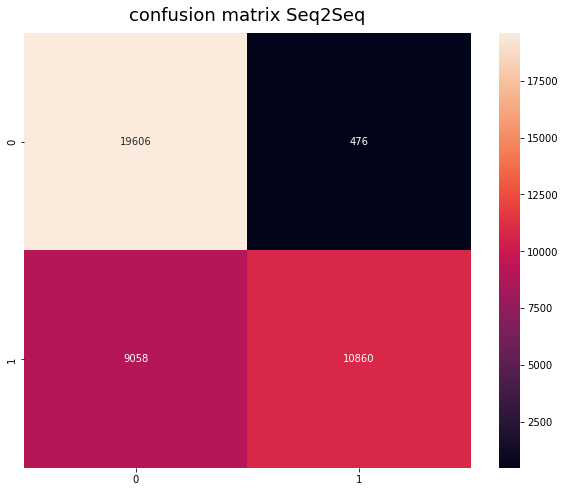

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(cm, annot=True, fmt="d")
heatmap.set_title('confusion matrix Seq2Seq', fontdict={'fontsize':18}, pad=12);

# Graphs


In [ ]:
#append to one list
train_loss1 = []
val_accuracies_appended = []

#run until max_epochs 
for i in range(0,config.max_epochs):
  train_loss1.extend(train_losses[i])
  val_accuracies_appended.extend(val_accuracies[i])

print(train_loss1) 
print(len(train_loss1))
print(val_accuracies_appended) 
print(len(val_accuracies_appended))

[-0.25382322, -0.76230574, -0.82773966, -0.8311537, -0.8389767, -0.84528315, -0.8608652, -0.8661012, -0.86251754, -0.86438596]
10
[0.50296875, 0.82609375, 0.83584375, 0.85009375, 0.865625, 0.8555625, 0.8378125, 0.85071875, 0.8240625, 0.88521875]
10


In [ ]:
train_loss2 = []
train_loss2 = [x * (-1) for x in train_loss1]

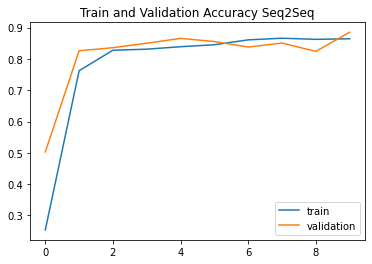

In [ ]:
#print graphs
from matplotlib import pyplot
pyplot.title('Train and Validation Accuracy Seq2Seq')
pyplot.plot(train_loss2, label='train')
pyplot.plot(val_accuracies_appended, label='validation')
pyplot.legend()
pyplot.show()

# Load Model

In [ ]:
#load model 
model = torch.load(PATH)
model.eval()

Seq2SeqAttention(
  (embeddings): Embedding(50480, 100)
  (lstm): LSTM(100, 32, bidirectional=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=-1)
  (loss_op): NLLLoss()
)

In [ ]:
#Get Data for Last layer
#Train Set
accuracy_train, predicted_train, Y_all_train, Y_all_Preds_train = evaluate_model_metrices(model, dataset.train_iterator)
#Test Set
accuracy_test, predicted_test, Y_all_test, Y_all_Preds_test = evaluate_model_metrices(model, dataset.test_iterator)

In [ ]:
#Classification Report
print(classification_report(Y_all_test, Y_all_Preds_test))

              precision    recall  f1-score   support

           1       0.67      0.98      0.79     20082
           2       0.97      0.50      0.66     19918

    accuracy                           0.74     40000
   macro avg       0.82      0.74      0.73     40000
weighted avg       0.82      0.74      0.73     40000



In [ ]:
#Classification Report
print(classification_report(Y_all_train, Y_all_Preds_train))

              precision    recall  f1-score   support

           1       0.90      0.91      0.91     63819
           2       0.91      0.90      0.91     64181

    accuracy                           0.91    128000
   macro avg       0.91      0.91      0.91    128000
weighted avg       0.91      0.91      0.91    128000



In [ ]:
import numpy as np
from numpy import asarray

In [ ]:
Y_RNN_Pred_Test = asarray(Y_all_Preds_test, dtype = 'int32')
Y_RNN_GroundProof_Test = asarray(Y_all_test, dtype = 'int32')
Y_RNN_Pred_Train = asarray(Y_all_Preds_train, dtype = 'int32')
Y_RNN_GroundProof_Train = asarray(Y_all_train, dtype = 'int32')

In [ ]:
#Save the tensors
%cd '/content/gdrive/My Drive/Colab Notebooks/Uni/IntroToDeep/IntroToDeep/Project/codes/Model_Seq2Seq_Attention/'
np.save('Y_Seq2Seq_Pred_Test', Y_RNN_Pred_Test)
np.save('Y_Seq2Seq_GroundProof_Test', Y_RNN_GroundProof_Test)
np.save('Y_Seq2Seq_Pred_Train', Y_RNN_Pred_Train)
np.save('Y_Seq2Seq_GroundProof_Train', Y_RNN_GroundProof_Train)

/content/gdrive/.shortcut-targets-by-id/1XNTZrFPo5LZhTNZ3l5LoLnleAlL4h-1v/IntroToDeep/Project/codes/Model_Seq2Seq_Attention
